In [8]:
import numpy as np
import pandas as pd 
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [9]:
ratings = pd.read_csv('./data/rating.csv')
anime = pd.read_csv('./data/anime.csv')

## anime data

In [10]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [11]:
anime.sort_values('members', ascending=False)[:10]

,anime_id,name,genre,type,episodes,rating,members
40,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
86,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
804,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
159,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796
19,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151
841,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
445,10620,Mirai Nikki (TV),"Action, Mystery, Psychological, Shounen, Super...",TV,26,8.07,657190
131,4224,Toradora!,"Comedy, Romance, School, Slice of Life",TV,25,8.45,633817


In [12]:
round(anime.describe(), 2)

,anime_id,rating,members
count,12294.00,12064.00,12294.00
mean,14058.22,6.47,18071.34
std,11455.29,1.03,54820.68
min,1.00,1.67,5.00
25%,3484.25,5.88,225.00
50%,10260.50,6.57,1550.00
75%,24794.50,7.18,9437.00
max,34527.00,10.00,1013917.00


## ratings data

In [13]:
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [14]:
round(ratings.describe(), 2)

,user_id,anime_id,rating
count,7813737.00,7813737.00,7813737.00
mean,36727.96,8909.07,6.14
std,20997.95,8883.95,3.73
min,1.00,1.00,-1.00
25%,18974.00,1240.00,6.00
50%,36791.00,6213.00,7.00
75%,54757.00,14093.00,9.00
max,73516.00,34519.00,10.00


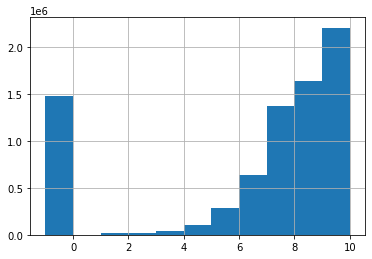

In [15]:
ratings['rating'].hist(bins=11)

In [16]:
len(ratings[ratings['rating'] == -1])

1476496

## preprocessing

### anime

In [17]:
anime.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [18]:
threshold = 10000
l_anime = anime[anime['members'] > threshold]

In [19]:
l_anime.isnull().sum()

anime_id     0
name         0
genre        2
type         4
episodes     0
rating      43
members      0
dtype: int64

In [20]:
d_anime = l_anime.dropna()

### rating

In [21]:
e_ratings = ratings[ratings.rating >= 0]

In [22]:
e_ratings.head()

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10


## merge

In [23]:
merge_df = e_ratings.merge(d_anime, left_on = 'anime_id', right_on='anime_id', suffixes=['_user', ''])
merge_df.head()

,user_id,anime_id,rating_user,name,genre,type,episodes,rating,members
0,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
1,3,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
2,5,8074,2,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
3,12,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
4,14,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892


In [24]:
df = merge_df[['user_id', 'name', 'rating_user']]
df = df.drop_duplicates(['user_id', 'name'])
df.head()

,user_id,name,rating_user
0,1,Highschool of the Dead,10
1,3,Highschool of the Dead,6
2,5,Highschool of the Dead,2
3,12,Highschool of the Dead,6
4,14,Highschool of the Dead,6


In [25]:
anime_pivot = df.pivot(index='name', columns='user_id', values='rating_user').fillna(0)
anime_pivot_sparse = csr_matrix(anime_pivot.values)

In [26]:
anime_pivot.head()

user_id,1,2,3,5,7,8,9,10,11,12,...,73507,73508,73509,73510,73511,73512,73513,73514,73515,73516
name,,,,,,,,,,,,,,,,,,,,,
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Memoire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Movie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//G.U. Returner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//G.U. Trilogy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
knn = NearestNeighbors(n_neighbors=9, algorithm='brute', metric='cosine')
model_knn = knn.fit(anime_pivot_sparse)

In [28]:
def searchAnime(title):
    print(anime_pivot[anime_pivot.index.str.contains(title)].index[0:])

In [29]:
searchAnime('Naruto')

Index(['Boruto: Naruto the Movie',
       'Boruto: Naruto the Movie - Naruto ga Hokage ni Natta Hi', 'Naruto',
       'Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo!',
       'Naruto Movie 2: Dai Gekitotsu! Maboroshi no Chiteiiseki Dattebayo!',
       'Naruto Movie 3: Dai Koufun! Mikazuki Jima no Animaru Panikku Dattebayo!',
       'Naruto Narutimate Hero 3: Tsuini Gekitotsu! Jounin vs. Genin!! Musabetsu Dairansen taikai Kaisai!!',
       'Naruto SD: Rock Lee no Seishun Full-Power Ninden',
       'Naruto Shippuuden: Shippuu! &quot;Konoha Gakuen&quot; Den',
       'Naruto Shippuuden: Sunny Side Battle',
       'Naruto Soyokazeden Movie: Naruto to Mashin to Mitsu no Onegai Dattebayo!!',
       'Naruto x UT', 'Naruto: Akaki Yotsuba no Clover wo Sagase',
       'Naruto: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo! Special: Konoha Annual Sports Festival',
       'Naruto: Honoo no Chuunin Shiken! Naruto vs. Konohamaru!!',
       'Naruto: Shippuuden Movie 1', 'Naru

In [30]:
anime = 'Naruto'

distance, indice = model_knn.kneighbors(anime_pivot.iloc[anime_pivot.index == anime].values.reshape(1, -1), n_neighbors=11)
for i in range(len(distance.flatten())):
    if i == 0:
        print('Recommendation if you like the anime {0}:\n'.format(anime))
    else:
        print('{0}: {1} with distance: {2}'.format(i, anime_pivot.index[indice.flatten()[i]], distance.flatten()[i]))

Recommendation if you like the anime Naruto:

1: Death Note with distance: 0.44815151601300474
2: Fullmetal Alchemist with distance: 0.5223248441198116
3: Bleach with distance: 0.5284777073449622
4: Fullmetal Alchemist: Brotherhood with distance: 0.5302955938928025
5: Code Geass: Hangyaku no Lelouch with distance: 0.5306948158335985
6: Sword Art Online with distance: 0.5307968338015507
7: Shingeki no Kyojin with distance: 0.5362968975112385
8: Dragon Ball Z with distance: 0.5425918533525473
9: Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo! with distance: 0.5463915214385635
10: Ao no Exorcist with distance: 0.5505920029303739


## pickle化

In [31]:
import pickle

In [25]:
with open('model_knn.pickle', 'wb') as f:
    pickle.dump(model_knn, f)
    
with open('anime_pivot.pickle', 'wb') as f:
    pickle.dump(anime_pivot, f)

In [7]:
animeTitles = pd.DataFrame(anime_pivot.index)
with open('animeTitles.pickle', 'wb') as f:
    pickle.dump(animeTitles, f)

NameError: name 'pd' is not defined

In [6]:
with open('animeTitles.pickle', 'rb') as f:
    animeTitles = pickle.load(f)
    

EOFError: Ran out of input